# Mapping the risk of avalanches on the Shara mountain

We map the risk of avalanches on the Shara mountain using previously trained machine learning models. 

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
import pandas as pd
from utils import AvalancheFeatures, plot_relative_importances, load_labels
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from joblib import load
import rasterio
import pickle
import joblib
from rasterio.plot import show

## Paths to required files

In [2]:
root = Path('../')

# Define path to the data files
fitted_models_path = root / 'fitted_models'
data_path = root / 'data'
tif_files = list(data_path.glob('*.tif'))

# Paths to trained models
models_path = root / 'fitted_models'
scaler_path = models_path / 'scaler.pkl'
model_path = models_path / 'dt.pkl'

# Path to output risk maps
results_path = root / 'results'

# Since there are many locations, and loading of data from tif files takes a long time, a dataframe with the design matrix was prepared and dumped to disk, so that it can be quickly loaded to save time.
design_matrix_path = data_path / 'features_all_coords.pkl'

# Destination path for storing tif with risk map
risk_map_path = results_path / f'risk_{model_path.stem}.tif'


## Locations for mapping

The features which are inputs to the machine learning models are saved in tif files. Each tif file covers the same spatial region, but with varying resolution. The land use tif file has the greatest resolution and will be used as a base for mapping avalanche risk.

In [3]:
# Precipitation and temperature were obtained as linear mappings of elevation, and are not used by the ML models.
tif_files = [
    p for p in tif_files if p.stem not in 
    {'Winter_air_temperature', 'Winter precipitation (mm)'}
]


most_coords = 0
print('Valid locations count')
for path in tif_files:
    with rasterio.open(path) as src:
        valid_coords_count = np.count_nonzero(src.dataset_mask())
        print(f'{path.stem}: {valid_coords_count}')
        if valid_coords_count > most_coords:
            most_coords = valid_coords_count
            highest_res_tif_path = path

Valid locations count
Normalized Difference Snow Index: 2434228
Land_use: 9737112
Plan curvature: 6231360
Profile curvature: 6231360
Terrain slope (degrees): 6238016
Aspect: 6231849
Elevation (m): 6231360


A helper function that returns the x and y coordinates, and band values from a tif file.

In [4]:
def read_tif(path):
    with rasterio.open(path) as src:
        rows, cols = np.nonzero(src.dataset_mask())
        x, y = src.xy(rows, cols)
        band = src.read(1)
        z = band[rows, cols]
        crs = src.crs
    return x, y, z, crs

Load points from the tif file with the highest resolution and use it to define the coordinates which are going to be sampled from other tif files.

In [5]:
x, y, _, crs = read_tif(highest_res_tif_path)
geometry = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x, y), crs=crs)

## Design matrix

The dataset is a GeoPandas GeoDataFrame, with the coordinates (the 'geometry' column) defined by the highest-resolution tif. The remaining columns are samples from all available tif files at those locations.

In [6]:
# For generating the dataset by reading tif files from disk, use the following function:
# features = AvalancheFeatures(
#     tif_paths=[data_path / file for file in tif_files],
#     coords=geometry['geometry'],
#     verbose=True
# )
# print(features.df.head())

if design_matrix_path.exists():
    with open(design_matrix_path, 'rb') as f:
        X = pickle.load(f)
else:
    features = AvalancheFeatures(
        tif_paths=[data_path / file for file in tif_files],
        coords=geometry['geometry'],
        verbose=True
    )
    X = features.get_X()

The training set does not have examples where `land_use` is `bare`, `snow` or `water`. As a hack, we are removing these columns from the design matrix.

In [7]:
X = X.drop(columns=['land_use_bare', 'land_use_snow', 'land_use_water'])

The data are standardized based on the means and stdevs of features computed from the train set.

In [8]:
# Standardize
with open(scaler_path, 'rb') as f:
    ss = joblib.load(f)
ss.set_output(transform='pandas')

# Make sure the order of columns in the design matrix
# is the same as in the scaler:
X = X[ss.feature_names_in_]

X_scaled = ss.transform(X)

## Inference with trained model

In [9]:
# Load trained model from disk
with open(model_path, 'rb') as f:
    model = joblib.load(f)

# Make sure the order of columns in the design matrix
# is the same as in the scaler:
X_scaled = X_scaled[model.feature_names_in_]

# Predict avalanche risk on provided locations
y_pred = model.predict_proba(X_scaled)


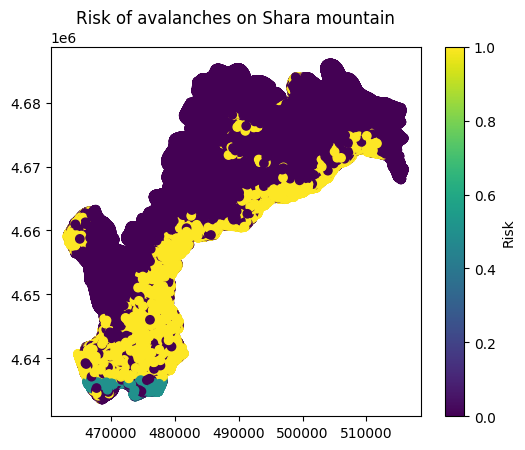

In [13]:
# Visualize
risk_gdf = gpd.GeoDataFrame(
    {'avalanche_risk': y_pred[:, 1]}, 
    geometry=gpd.points_from_xy(X['x_coord'], X['y_coord']),
    crs=crs 
)
risk_gdf.iloc[::10,].plot(
    column='avalanche_risk',
    legend=True,
    legend_kwds={'label': 'Risk', 'orientation': 'vertical'}
)
plt.title('Risk of avalanches on Shara mountain')
plt.show()

## Create tif file with risk values

In [14]:
# Coordinates
coords = np.array([[p.x, p.y] for p in risk_gdf['geometry']])
# Find indices of pixels from land_use tif that correspond to coordinates of points for which we have avalanche risk values
with rasterio.open(highest_res_tif_path) as src:
    rows, cols = rasterio.transform.rowcol(src.transform, coords[:, 0], coords[:, 1])
rows = rows.astype(int)
cols = cols.astype(int)

Create numpy arrays with risk values and masks.

In [15]:
risks = np.zeros((rows.max()+1, cols.max()+1), dtype=np.float32)
masks = np.zeros((rows.max()+1, cols.max()+1), dtype=np.uint8)
risks[rows, cols] = risk_gdf['avalanche_risk']
masks[rows, cols] = 255

Write to tif using the existing tif with the highest resolution as a blueprint.

In [16]:
src = rasterio.open(highest_res_tif_path)

dst = rasterio.open(
    risk_map_path,
    'w',
    driver=src.driver,
    height=risks.shape[0],
    width=risks.shape[1],
    count=1,
    dtype=risks.dtype,
    crs=src.crs,
    transform=src.transform
)
dst.write(risks, 1)
dst.write_mask(masks)
dst.close()

src.close()

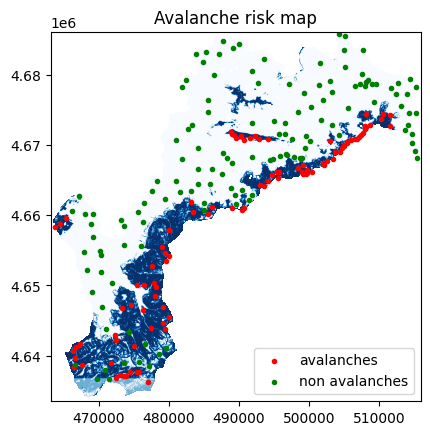

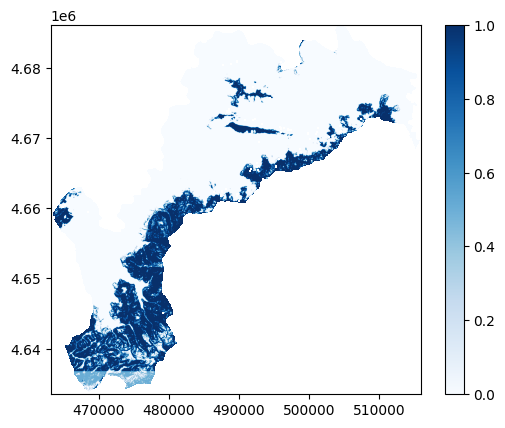

In [17]:
# Visualization of tif file

avalanches_df = gpd.read_file(data_path / "Avalanches.shp")
non_avalanches_df = gpd.read_file(data_path / "Non avalanches.shp")

with rasterio.open(risk_map_path) as src:
    fig, ax = plt.subplots()
    rasterio.plot.show(src, ax=ax, cmap='Blues')
    avalanches_df.plot(ax=ax, marker='.', color='r', label='avalanches')
    non_avalanches_df.plot(ax=ax, marker='.', color='g', label='non avalanches')
    ax.legend()
    ax.set_title('Avalanche risk map')
    plt.savefig(results_path / f'risk_map_{model_path.stem}_with_avalanche_locations.svg', bbox_inches='tight')

    fig, ax = plt.subplots()
    retted = rasterio.plot.show(src, ax=ax, cmap='Blues')
    im = retted.get_images()[0]
    fig.colorbar(im, ax=ax)
    plt.savefig(results_path / f'risk_map_{model_path.stem}.svg', bbox_inches='tight')

    plt.show()